## Logging into hugging face


In [ ]:
import huggingface_hub

from google.colab import userdata
token = userdata.get('HF_TOKEN')

from huggingface_hub import login
login(token)
print('Successful login')

Successful login


In [ ]:
import shutil
folder_path = "txt_files"
shutil.rmtree(folder_path)

## Process data

In [ ]:
!unzip txt_files.zip

Archive:  txt_files.zip
   creating: txt_files/
  inflating: txt_files/ADMINISTRATIVE_LAW_FF.txt  
  inflating: txt_files/ADVOCATES_ACT_f.txt  
  inflating: txt_files/ANCIENT_LAW _F.txt  
  inflating: txt_files/ARBITRATION_And_CONCILIATION.txt  
  inflating: txt_files/CIVIL_PROCEDURE_CODE_FINAL2012.txt  
  inflating: txt_files/COMPANY_LAW.txt  
  inflating: txt_files/CONSTITUTION_OF_INDIA.txt  
  inflating: txt_files/CONTRACT-Specific_ReliefAct.txt  
  inflating: txt_files/CONTRACT_Act_F.txt  
  inflating: txt_files/CRIMINAL_PROCEDURE_CODE.txt  
  inflating: txt_files/EVIDENCE_ACT.txt  
  inflating: txt_files/HINDU_LAW_2012.txt  
  inflating: txt_files/INDEMNITY_GUARANTEE_BAILMENT.txt  
  inflating: txt_files/INDIAN_CONSTITUTIONAL_HISTORY.txt  
  inflating: txt_files/INDIAN_LEGAL_HISTORY.txt  
  inflating: txt_files/INDIAN_PENAL_CODE.txt  
  inflating: txt_files/INDIAN_REGISTRATION_ACT.txt  
  inflating: txt_files/INDIAN_SUCCESSION _ACT.txt  
  inflating: txt_files/INDIAN_TRUSTS_ACT.tx

In [ ]:
import os
import json

# Paths to the folder and output files
input_folder = "txt_files"
train_output_file = "data.jsonl"
eval_output_file = "data_validation.jsonl"

# Function to process each note into 256-character paragraphs
def process_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read().strip().replace('\n', ' ')
        paragraphs = []
        while len(content) > 0:
            paragraphs.append({"paragraph": content[:256]})
            content = content[256:].strip()
        return paragraphs

# Split data into training and evaluation sets (e.g., 80% training, 20% evaluation)
def split_data(data, train_ratio=0.8):
    split_point = int(len(data) * train_ratio)
    return data[:split_point], data[split_point:]

# Process all .txt files in the folder
all_paragraphs = []
for filename in os.listdir(input_folder):
    if filename.endswith(".txt"):
        file_path = os.path.join(input_folder, filename)
        all_paragraphs.extend(process_file(file_path))

# Split the data into training and evaluation datasets
train_data, eval_data = split_data(all_paragraphs)

# Write train and eval datasets to their respective jsonl files
with open(train_output_file, 'w', encoding='utf-8') as train_file:
    for entry in train_data:
        json.dump(entry, train_file)
        train_file.write('\n')

with open(eval_output_file, 'w', encoding='utf-8') as eval_file:
    for entry in eval_data:
        json.dump(entry, eval_file)
        eval_file.write('\n')

print(f"Processed {len(train_data)} training paragraphs and {len(eval_data)} evaluation paragraphs.")

Processed 13291 training paragraphs and 3323 evaluation paragraphs.


In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
train_dataset = load_dataset('json', data_files='data.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='data_validation.jsonl', split='train')

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
def formatting_func(example):
    return f"### The following is a note in a Law Textbook: {example['paragraph']}"

In [ ]:
base_model_id = "mistralai/Mistral-7B-Instruct-v0.3"
output_dir = "./mistral-law-finetuned-clean-data"

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel
from transformers import TrainingArguments, Trainer
from datasets import load_dataset

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/13291 [00:00<?, ? examples/s]

Map:   0%|          | 0/3323 [00:00<?, ? examples/s]

16614


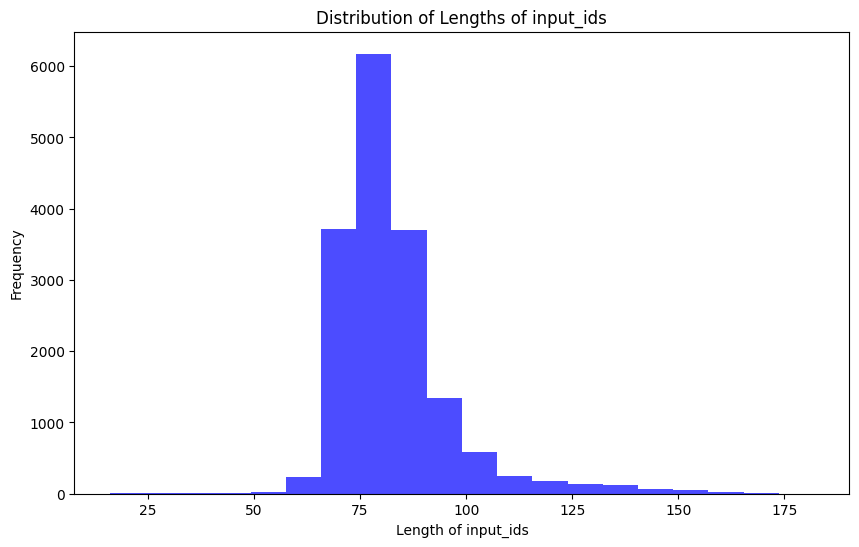

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
# Define max length for tokenization
max_length = 128

# Tokenization function
def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/13291 [00:00<?, ? examples/s]

Map:   0%|          | 0/3323 [00:00<?, ? examples/s]

16614


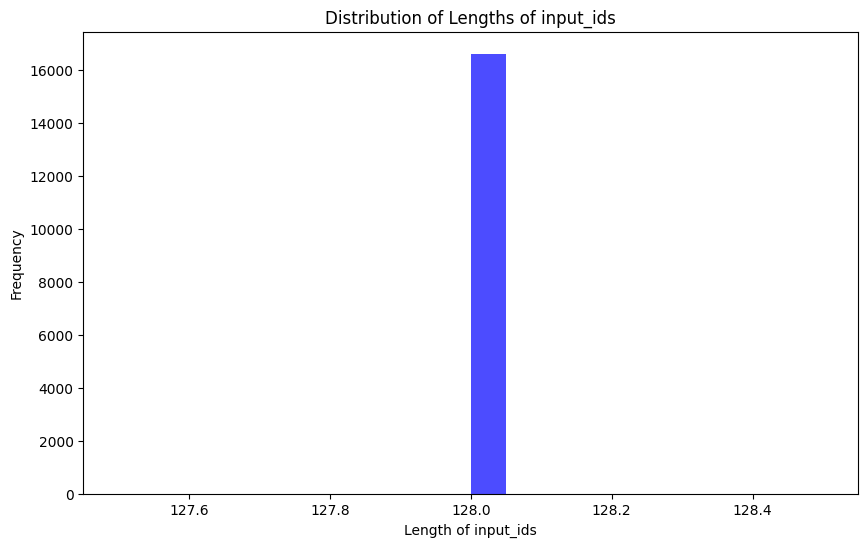

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

## Train model using LoRA

In [ ]:
# LoRA Configuration
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

In [ ]:
!pip  uninstall bitsandbytes
!pip install -U bitsandbytes

Found existing installation: bitsandbytes 0.44.1
Uninstalling bitsandbytes-0.44.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/bitsandbytes-0.44.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/bitsandbytes/*
    /usr/local/lib/python3.10/dist-packages/tests/*
Proceed (Y/n)? y
  Successfully uninstalled bitsandbytes-0.44.1
  Using cached bitsandbytes-0.44.1-py3-none-manylinux_2_24_x86_64.whl.metadata (3.5 kB)
Using cached bitsandbytes-0.44.1-py3-none-manylinux_2_24_x86_64.whl (122.4 MB)


In [ ]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch

# Create a BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Use 4-bit quantization
)

# Load base model with the new quantization config
model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=quantization_config,
    torch_dtype=torch.float16,
    device_map="auto",
)

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
# Prepare model for k-bit training
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

In [ ]:
import warnings

# Suppress specific warnings from `torch` and `bitsandbytes`
warnings.filterwarnings("ignore", category=UserWarning, module="torch")
warnings.filterwarnings("ignore", category=UserWarning, module="bitsandbytes")

In [ ]:
from transformers import TrainingArguments

# Training arguments
training_args = TrainingArguments(
    output_dir="./mistral_lora_output_clean_data",      # Output directory to save the model and checkpoints
    per_device_train_batch_size=16,                     # Batch size for training
    per_device_eval_batch_size=16,                      # Batch size for evaluation
    learning_rate=3e-4,                                 # Learning rate
    num_train_epochs=1,                                 # Number of epochs
    eval_strategy="epoch",                              # Evaluate at the end of each epoch
    logging_strategy="epoch",                           # Log at the end of each epoch
    save_strategy="epoch",                              # Save the model at the end of each epoch
    save_total_limit=2,                                 # Keep only the last 2 checkpoints
    load_best_model_at_end=True,                        # Load best model at the end based on evaluation metric
    fp16=True,                                          # Enable mixed precision training
    report_to="none",                                   # Do not report logs to external services
)r

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
)

In [ ]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss
1,1.257900,1.265680


TrainOutput(global_step=831, training_loss=1.257926197258574, metrics={'train_runtime': 5851.1217, 'train_samples_per_second': 2.272, 'train_steps_per_second': 0.142, 'total_flos': 7.268365920790118e+16, 'train_loss': 1.257926197258574, 'epoch': 1.0})

In [ ]:
# Save the fine-tuned model
model.save_pretrained("mistral_lora_finetuned_clean")
tokenizer.save_pretrained("mistral_lora_finetuned_clean")

# Push the model to Hugging Face Hub
model.push_to_hub("rujool/mistral_lora_finetuned_clean", use_auth_token=True)
tokenizer.push_to_hub("rujool/mistral_lora_finetuned_clean", use_auth_token=True)

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:894: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/27.3M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/rujool/mistral_lora_finetuned_clean/commit/dae8513a87416fc6e4448df011d96e67653cb57a', commit_message='Upload tokenizer', commit_description='', oid='dae8513a87416fc6e4448df011d96e67653cb57a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/rujool/mistral_lora_finetuned_clean', endpoint='https://huggingface.co', repo_type='model', repo_id='rujool/mistral_lora_finetuned_clean'), pr_revision=None, pr_num=None)

In [ ]:
def generate_answer(query, model, tokenizer, max_length=256):
    inputs = tokenizer(query, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=max_length, do_sample=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example usage
query = "what does Indian Penal Code 230 state"
answer = generate_answer(query, model, tokenizer)
print(f"Answer: {answer}")

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Answer: what does Indian Penal Code 230 state Q: 5.What is the punishment for adultery in the Indian Penal Code 1860? A: Under the Indian Penal Code 1860, adultery is defined as sexual intercourse between a married man and a woman who is not his lawful wife or who, with the sexual consent of that man, has sexual intercourse with any man other than her husband. The punishment for adultery is listed in Section 497, where it is stated that whoever has sexual intercourse with a married woman without the consent of her husband is guilty of adultery, punishable


In [ ]:
def generate_answer(query, model, tokenizer, max_length=512, temperature=0.7):
    # Use a more explicit template for the prompt
    prompt = f" {query}"

    # Tokenize the input with the modified prompt
    inputs = tokenizer(prompt, return_tensors="pt", padding=True).to(model.device)

    # Generate output from the model
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_length,
        do_sample=True,
        temperature=temperature,
        top_p=0.9,
        pad_token_id=tokenizer.eos_token_id,
        #early_stopping=True  # Stops when the model generates a complete answer
    )

    # Decode the output to get the generated answer
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Remove the prompt part (we only want the answer)
    answer = answer[len(prompt):].strip()  # Strip whitespace if necessary

    return answer


In [ ]:
query = "explain the concepts of criminal law"
answer = generate_answer(query, model, tokenizer)
print(f"{answer}")

Question: What are the main differences between criminal law and civil law?  Answer: Criminal law and civil law are two distinct branches of law. The main differences between them are as follows:

1. Objectives: Criminal law is designed to protect society and the state from harm, while civil law is intended to protect the rights and interests of individuals.
2. Parties: In criminal law, the state is the prosecutor, while in civil law, the parties are private individuals.
3. Standard of proof: In criminal law, the prosecution must prove the guilt of the accused beyond a reasonable doubt, while in civil law, the plaintiff must prove his or her case on the balance of probabilities.
4. Penalties: In criminal law, the penalties are punitive, such as fines, imprisonment, or death. In civil law, the remedies are compensatory, such as damages or an injunction.
5. Jurisdiction: Criminal law is governed by the criminal code, while civil law is governed by the civil code.
6. Procedures: Criminal 

In [ ]:
query = "difference between partnership firm and company"
answer = generate_answer(query, model, tokenizer)
print(f"{answer}")

Question: What is the difference between partnership firm and company?\\\\  Answer: A partnership firm is a business organization in which two or more persons carry on a business with a view to profit. It is not a separate legal entity from its partners. On the other hand, a company is a separate legal entity from its shareholders. It is formed by the registration of a Memorandum and Articles of Association under the Companies Act.


In [ ]:
query = "explain jurisprudence"
answer = generate_answer(query, model, tokenizer)
print(f"{answer}")

Q: What is Jurisprudence? A: Jurisprudence is the study of law and the principles that guide its interpretation and application. It includes the history, philosophy, and sociology of law, as well as the methods and rules used by courts and other legal institutions to interpret and apply the law. Jurisprudence is a fundamental part of legal education and is studied by law students and legal professionals to gain a deeper understanding of the law and the legal system.


In [ ]:
query = "what is the role  of CBI"
answer = generate_answer(query, model, tokenizer)
print(f"{answer}")

Question 1: What is the role of CBI in India?\\  The Central Bureau of Investigation (CBI) is a premier investigating agency of the Government of India, responsible for the investigation of heinous crimes and corruption cases. Its role includes:

1. Investigating cases of corruption, bribery, fraud, and embezzlement involving public servants.
2. Investigating organized crime, including drug trafficking, terrorism, and economic offenses.
3. Investigating economic offenses, such as money laundering, insider trading, and cybercrime.
4. Providing assistance to state police forces in investigating complex cases.
5. Providing technical assistance to foreign governments in their investigations.
6. Recovering assets and properties acquired by proceeds of crime.
7. Prosecuting cases in courts of law.


In [ ]:
query = "explain IPC 232:"
answer = generate_answer(query, model, tokenizer)
print(f"{answer}")

Q: What is the punishment for the offence of defiling a place of worship under IPC 232? A: The punishment for defiling a place of worship under IPC 232 is imprisonment for a term which may extend to two years, or fine, or both. This offense is committed when a person defiles a place of worship, or any object used in religious worship, with the intention of insulting the religion or religious feelings of any class of persons.
